In [1]:
import numpy as np
import pandas as pd
import json as j
import urllib
import gzip
import nltk



nltk.download('stopwords')
from nltk.stem import PorterStemmer
from sklearn.model_selection import train_test_split
!pip install gensim
from gensim.models import KeyedVectors
from nltk.corpus import stopwords

from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Using TensorFlow backend.


In [ ]:
import re
  import string
from sklearn.feature_extraction.text import CountVectorizer
def clean_text(text):
    text = str(text)
   
    
    text =  text.split()
    words = []
    for word in text:
      exclude = set(string.punctuation)
      word = ''.join(ch for ch in word if ch not in exclude)
      if word in stops:
        continue
      try: 
        words.append(ps.stem(word))
      except UnicodeDecodeError:
        words.append(word)
    text = " ".join(words)
    
    
    return text.lower()


#Process data

stops = set(stopwords.words("english"))

ps = PorterStemmer()

dataset = 'https://www.dropbox.com/s/jr4kar4nppqem4n/fake_or_real_news.csv?dl=1'

f = pd.read_csv(dataset)  

f.label = f.label.map(dict(REAL=1, FAKE=0))

f

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...,...
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


In [ ]:
f = f[1:100]

X_train, X_test, y_train, y_test = train_test_split(f['title'], f.label, test_size=0.2)

X_cleaned_train = [clean_text(x) for x in X_train]

X_cleaned_test = [clean_text(x) for x in X_test]



X_cleaned_train[0]



'donald trump hillari clinton caus tremend death'

In [ ]:
import tokenize
from keras.preprocessing.text import Tokenizer

MAX_NB_WORDS = 20000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_cleaned_train + X_cleaned_test)
print('Finished Building Tokenizer')

train_sequence = tokenizer.texts_to_sequences(X_cleaned_train)
print('Finished Tokenizing Training')

test_sequence = tokenizer.texts_to_sequences(X_cleaned_test)
print('Finished Tokenizing test')



Finished Building Tokenizer
Finished Tokenizing Training
Finished Tokenizing test


In [ ]:
from gensim.models import KeyedVectors
EMBEDDING_FILE = 'https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(EMBEDDING_FILE, binary=True)
word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

nb_words = min(20000, len(word_index))

embedding_matrix = np.zeros((nb_words, 300))


for word, i in word_index.items():
    try:
      embedding_vector = word2vec.word_vec(word)
      if embedding_vector is not None and i < 7000:
        embedding_matrix[i] = embedding_vector
    except (KeyError, IndexError) as e:
      continue

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Found 606 unique tokens


In [ ]:
from keras.models import Sequential

from keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

kVECTORLEN = 60

model = Sequential()
model.add(Embedding(5000, 500, input_length=50))
model.add(LSTM(125))
model.add(Dropout(0.4))
model.add(Dense(1, activation='relu'))
#model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())


#test_sequence

train_sequence = sequence.pad_sequences(train_sequence, maxlen=50)
test_sequence = sequence.pad_sequences(test_sequence, maxlen=50)


history = model.fit(train_sequence, y_train, validation_data=(test_sequence, y_test), epochs=20, batch_size=64)

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 50, 500)           2500000   
_________________________________________________________________
lstm_23 (LSTM)               (None, 125)               313000    
_________________________________________________________________
dropout_23 (Dropout)         (None, 125)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 126       
Total params: 2,813,126
Trainable params: 2,813,126
Non-trainable params: 0
_________________________________________________________________
None
Train on 79 samples, validate on 20 samples
Epoch 1/20
79/79 [==============================] - 7s 85ms/step - loss: 5.2745 - acc: 0.4304 - val_loss: 1.5278 - val_acc: 0.4000
Epoch 2/20
79/79 [==============================] - 0s 6ms/st

In [ ]:
scores = model.evaluate(test_sequence, y_test, verbose=0)
accuracy = (scores[1]*100)

print("Accuracy: {:.2f}%".format(scores[1]*100))



Accuracy: 75.00%


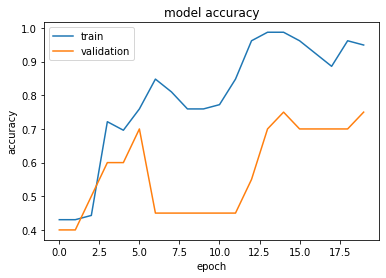

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()